In [ ]:
# Differential methylation of neutrophil cohort

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [2]:
import NotebookImport
from Setup.Imports import *

import Setup.DX_Imports as dx
import Parallel.Age_HIV_Features as fx
import statsmodels.api as sm
import matplotlib.gridspec as gridspec


importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

### Read in Validation Data

In [3]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [4]:
df_hiv =  pd.read_csv(path + 'BMIQ_Hannum2.csv', index_col=0)

importing IPython notebook from Validation/Process_Clinical

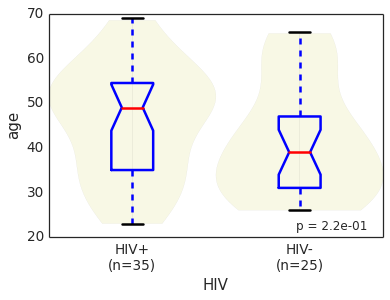

In [5]:
import Validation.Process_Clinical as clin

In [6]:
cd4_models = pd.read_csv(path + 'cd4_mv_models.csv', index_col=0,
                     header=[0,1])
neu_models = pd.read_csv(path + 'neu_mv_models.csv', index_col=0,
                     header=[0,1])

In [7]:
mm_cd4 = df_hiv.ix[:, ti(clin.cell_type == 'CD4')].mean(1)
mm_neu = df_hiv.ix[:, ti(clin.cell_type == 'Neu')].mean(1)

In [8]:
ct = pd.crosstab(neu_models.model.HIV > 0, mm_neu < .5)
(1.*ct.ix[1,1] + ct.ix[0,0]) / ct.sum().sum()

0.5386107861391686

In [9]:
ct = pd.crosstab(cd4_models.model.HIV > 0, mm_cd4 < .5)
(1.*ct.ix[1,1] + ct.ix[0,0]) / ct.sum().sum()

0.7031731450509977

In [10]:
ann = dx.probe_annotations.sort(['Chromosome','Genomic_Coordinate'])

In [11]:
mm = df_hiv.mean(1)

In [12]:
monocyte_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/monocyte_age_corr.csv',
                            index_col=0, squeeze=True)
cd4_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/CD4T_age_corr.csv',
                            index_col=0, squeeze=True)
neu_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/neutrophils_age_corr.csv',
                            index_col=0, squeeze=True)
beta_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/Beta_age_corr.csv',
                            index_col=0, squeeze=True)

In [13]:
dd = fx.r4.multi_variate.HIV > 0
dd.name = 'up'
hiv_dx = fx.g_hiv
hiv_dx.name = 'hiv'

dx_hiv = combine(hiv_dx, dd).replace({'up':'neither','hiv':'hiv_down', 'both':'hiv_up'})
dx_hiv.value_counts()

neither     391683
hiv_down     46220
hiv_up       35141
dtype: int64

5% FDR, because I'm doing a 1 sided test

In [16]:
cd4_up = bhCorrection(cd4_models.drop1.p.ix[ti(dx_hiv == 'hiv_up')]) < .1
cd4_up = (cd4_up & (cd4_models.model.HIV.ix[cd4_up.index] > 0))
cd4_down = bhCorrection(cd4_models.drop1.p.ix[ti(dx_hiv == 'hiv_down')]) < .1
cd4_down = (cd4_down & (cd4_models.model.HIV.ix[cd4_down.index] < 0))

In [22]:
neu_up = bhCorrection(neu_models.drop1.p.ix[ti(dx_hiv == 'hiv_up')]) < .1
neu_up = (neu_up & (neu_models.model.HIV.ix[neu_up.index] > 0))
neu_down = bhCorrection(neu_models.drop1.p.ix[ti(dx_hiv == 'hiv_down')]) < .1
neu_down = (neu_down & (neu_models.model.HIV.ix[neu_down.index] < 0))

In [30]:
cd4_up = bhCorrection(cd4_models.drop1.p.ix[ti((dx_hiv == 'hiv_up') & (fx.mm > .5))]) < .1
cd4_up = (cd4_up & (cd4_models.model.HIV.ix[cd4_up.index] > 0))
cd4_down = bhCorrection(cd4_models.drop1.p.ix[ti((dx_hiv == 'hiv_down') & (fx.mm < .5))]) < .1
cd4_down = (cd4_down & (cd4_models.model.HIV.ix[cd4_down.index] < 0))

In [31]:
neu_up = bhCorrection(neu_models.drop1.p.ix[ti((dx_hiv == 'hiv_up') & (fx.mm > .5))]) < .1
neu_up = (neu_up & (neu_models.model.HIV.ix[neu_up.index] > 0))
neu_down = bhCorrection(neu_models.drop1.p.ix[ti((dx_hiv == 'hiv_down') & (fx.mm < .5))]) < .1
neu_down = (neu_down & (neu_models.model.HIV.ix[neu_down.index] < 0))

In [55]:
neu_down.value_counts()

False    14353
True      1688
dtype: int64

In [20]:
cd4_down.value_counts()

False    15608
True       433
dtype: int64

In [21]:
fisher_exact_test(neu_down, cd4_down)

odds_ratio    4.96e+00
p             4.80e-44
dtype: float64

In [22]:
fisher_exact_test(cd4_up, neu_up)

odds_ratio    4.10e+00
p             6.44e-06
dtype: float64

In [23]:
cd4_up.mean(), cd4_down.mean(), neu_up.mean(), neu_down.mean()

(0.0036793017883117994,
 0.026993329592918149,
 0.2204158466672371,
 0.10523034723520977)

In [24]:
cd4_up.value_counts()

False    11644
True        43
dtype: int64

In [324]:
dd = neu_down
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

In [26]:
keepers = fx.pred_c.index.intersection(ti(fx.hiv == 'HIV+'))
v = np.log2(fx.labs['CD4/CD8 ratio']).dropna()
df = fx.df_hiv.ix[:, keepers]
df = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
#rr = screen_feature(v.ix[keepers], spearman_pandas, df)

In [27]:
rr = df.ix[:, v.index].T.corrwith(v)

In [28]:
hcp5 = ti(ann.Gene_Symbol == 'HCP5')
rr.rank(ascending=False).ix[hcp5].order().head()

Composite Element REF
cg01082299      32
cg00218406      53
cg23232773     133
cg25843003    1268
cg18808777    3877
dtype: float64

In [23]:
wb_cutoff = fx.r4.HIV_LR.p.ix[ti(dx_hiv != 'neither')].max()
neu_down_cutoff = neu_models.drop1.p.ix[ti(neu_down)].max()

In [20]:
probes = ti(ann.Gene_Symbol == 'HCP5')
cc = pd.Series(colors[1], probes)
cc[probe] = colors[0]

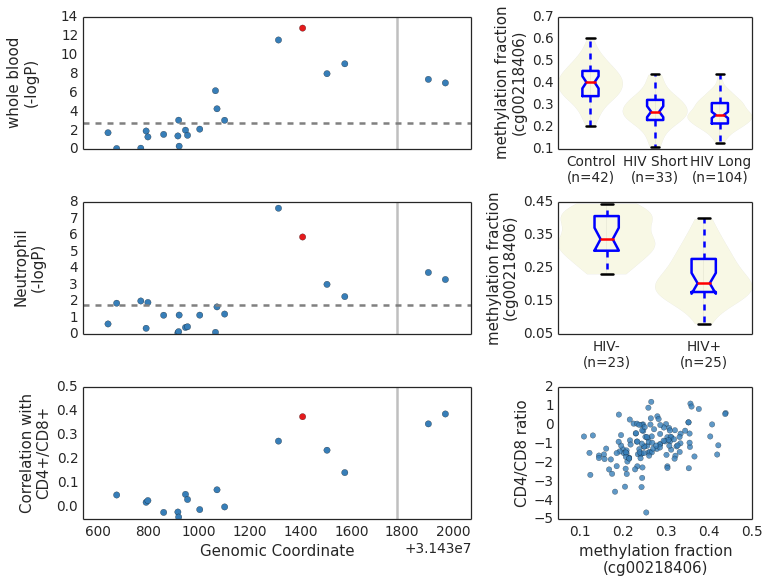

In [33]:
probes = ti(ann.Gene_Symbol == 'HCP5')
probe = 'cg00218406'
plt.figure(figsize=(12,9))
fig = plt.gcf()
gs1 = gridspec.GridSpec(3, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(6)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[probes]),
               s=40, color=cc, alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
axs[0].axhline(-1*np.log10(wb_cutoff), color='grey', ls='--')
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(neu_models.drop1.p.ix[probes]),
               s=40, color=cc, alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
axs[2].axhline(-1*np.log10(neu_down_cutoff), color='grey', ls='--')

rr = df.ix[probes, v.index].T.corrwith(v)

series_scatter(ann.Genomic_Coordinate.ix[probes], 
              rr.ix[probes], s=40, color=cc, alpha=1, edgecolor='black',
              ax=axs[4], ann=None)

for ax in [axs[0], axs[2], axs[4]]:
    ax.axvline(31431780, color='grey', alpha=.5)
    ax.set_xbound(ann.Genomic_Coordinate.ix[probes].min() - 100,
                  ann.Genomic_Coordinate.ix[probes].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
    
axs[0].set_xticks([])
axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('Neutrophil\n(-logP)\n')
axs[4].set_ylabel('Correlation with\nCD4+/CD8+')
axs[4].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix[probe],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1],
                   ann=None)
violin_plot_pandas(clin.hiv.ix[ti(clin.cell_type == 'Neu')], df_hiv.ix[probe], 
                   ax=axs[3], order=['HIV-','HIV+'],
                   ann=None)

series_scatter(fx.df_hiv.ix[probe].ix[keepers], 
               np.log2(fx.labs['CD4/CD8 ratio']).dropna(),
               s=30, color=colors[1], alpha=.8, edgecolor='black',
               ax=axs[5], ann=None)

for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))
    
axs[5].set_xlabel('methylation fraction \n({})'.format(probe))

axs[3].set_yticks([.05,.15,.25,.35,.45])
axs[5].set_xticks([.1,.2,.3,.4,.5])
axs[4].set_ylim(-.05, .5)
#fig.tight_layout()
fig.savefig(FIGDIR + 'HCP5_fig.pdf', dpi=200)

In [496]:
direction = (fx.r4.multi_variate.HIV > 0) == (fx.mm > .5)
direction.mean()

0.49823279342220173

In [498]:
direction.value_counts()

False    243614
True     241898
dtype: int64

In [504]:
rr.rank(pct=True, ascending=False).ix[probe]

0.00010916311028357692

In [511]:
neu_models.drop1.p.ix[probe]

1.38396503141e-06

In [508]:
neu_models.drop1.p.ix[ti(neu_down)].rank().ix[probe]

77.0

In [506]:
fx.r4.HIV_LR.p.rank(pct=True).ix[probe]

0.0093427144952133011

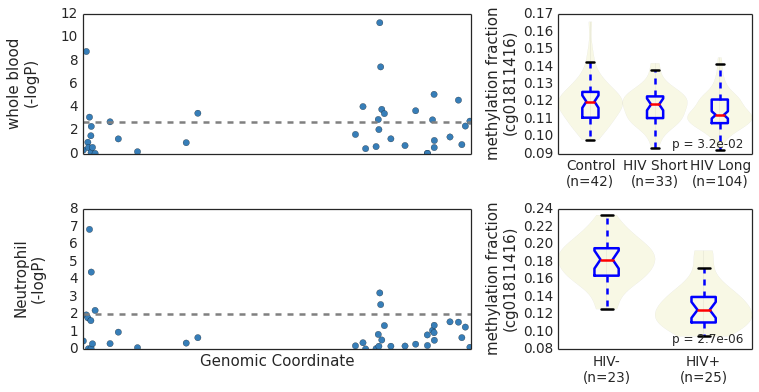

In [300]:
probes = ti(ann.Gene_Symbol == 'CABC1')
probe = neu_models.drop1.p.ix[probes.intersection(ti())].idxmin()
plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(2, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(4)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
axs[0].axhline(-1*np.log10(wb_cutoff), color='grey', ls='--')
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(neu_models.drop1.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
axs[2].axhline(-1*np.log10(cd4_down_cutoff), color='grey', ls='--')

for ax in [axs[0], axs[2]]:
    ax.set_xbound(ann.Genomic_Coordinate.ix[probes].min() - 100,
                  ann.Genomic_Coordinate.ix[probes].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
axs[0].set_xticks([])
axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('Neutrophil\n(-logP)\n')
axs[2].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix[probe],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1])
violin_plot_pandas(clin.hiv.ix[ti(clin.cell_type == 'Neu')], df_hiv.ix[probe], 
                   ax=axs[3], order=['HIV-','HIV+'])
for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))
    
#axs[3].set_yticks([.25,.35,.45,.55,.65])
#axs[5].set_xticks([.1,.2,.3,.4,.5])
#plt.tight_layout()

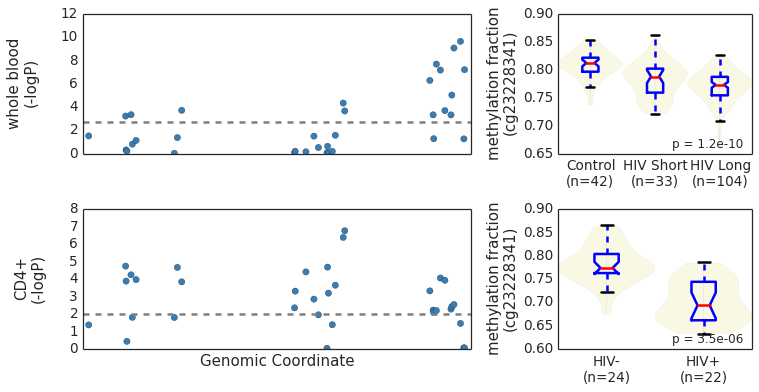

In [201]:
probe = 'cg23228341'
probes = ti(ann.Gene_Symbol == 'TAP1')
plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(2, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(4)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
axs[0].axhline(-1*np.log10(wb_cutoff), color='grey', ls='--')
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(cd4_models.drop1.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
axs[2].axhline(-1*np.log10(cd4_down_cutoff), color='grey', ls='--')

for ax in [axs[0], axs[2]]:
    ax.set_xbound(ann.Genomic_Coordinate.ix[probes].min() - 100,
                  ann.Genomic_Coordinate.ix[probes].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
axs[0].set_xticks([])
axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('CD4+\n(-logP)\n')
axs[2].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix[probe],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1])
violin_plot_pandas(clin.hiv.ix[ti(clin.cell_type == 'CD4')], df_hiv.ix[probe], 
                   ax=axs[3], order=['HIV-','HIV+'])
for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))
    
#axs[3].set_yticks([.25,.35,.45,.55,.65])
#axs[5].set_xticks([.1,.2,.3,.4,.5])
#plt.tight_layout()

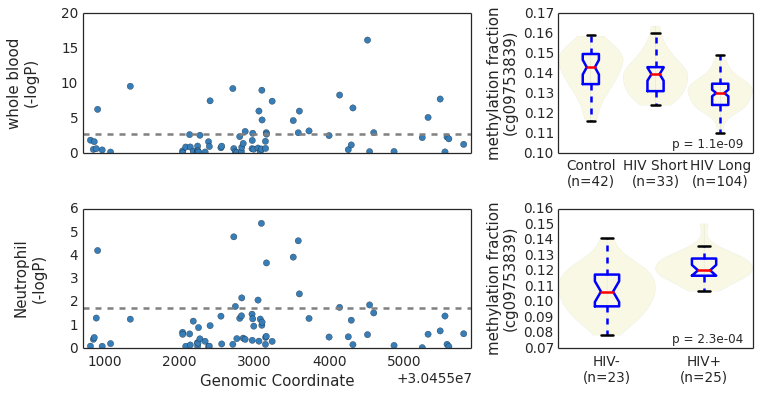

In [515]:
probes = ti(ann.Gene_Symbol == 'HLA-E')
probe = neu_models.drop1.p.ix[probes].idxmin()
plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(2, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(4)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
axs[0].axhline(-1*np.log10(wb_cutoff), color='grey', ls='--')
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(neu_models.drop1.p.ix[probes]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
axs[2].axhline(-1*np.log10(cd4_down_cutoff), color='grey', ls='--')

for ax in [axs[0], axs[2]]:
    ax.set_xbound(ann.Genomic_Coordinate.ix[probes].min() - 100,
                  ann.Genomic_Coordinate.ix[probes].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
axs[0].set_xticks([])
#axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('Neutrophil\n(-logP)\n')
axs[2].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix[probe],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1])
violin_plot_pandas(clin.hiv.ix[ti(clin.cell_type == 'Neu')], df_hiv.ix[probe], 
                   ax=axs[3], order=['HIV-','HIV+'])
for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))

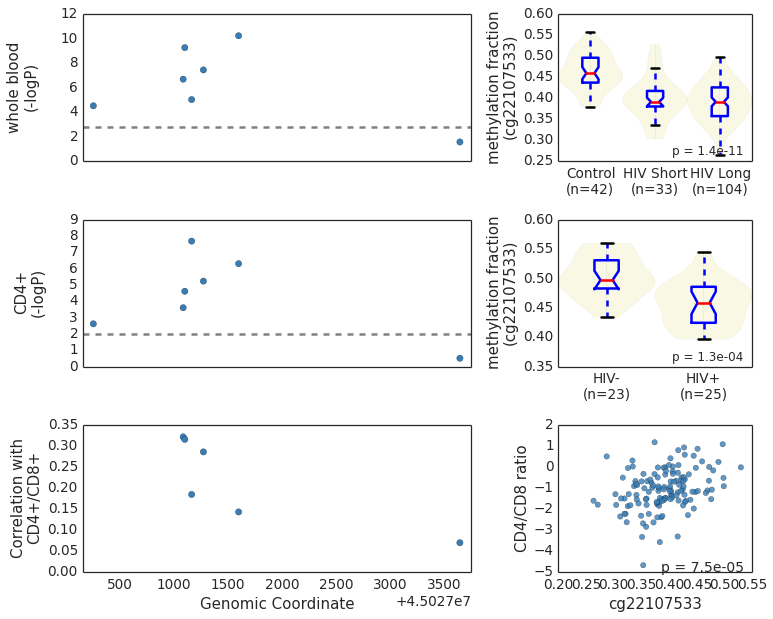

In [176]:
import matplotlib.gridspec as gridspec

probe = 'cg22107533'
plt.figure(figsize=(12,10))
gs1 = gridspec.GridSpec(3, 2, width_ratios=[4,2], hspace=.4, wspace=.3)
axs = [plt.subplot(gs1[i]) for i in range(6)]

series_scatter(ann.Genomic_Coordinate, 
               -1*np.log10(fx.r4.HIV_LR.p.ix[hcp5]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[0], ann=None)
axs[0].axhline(-1*np.log10(wb_cutoff), color='grey', ls='--')
series_scatter(ann.Genomic_Coordinate,
               -1*np.log10(neu_models.drop1.p.ix[hcp5]),
               s=40, color=colors[1], alpha=1, edgecolor='black',
               ax=axs[2], ann=None)
axs[2].axhline(-1*np.log10(cd4_down_cutoff), color='grey', ls='--')

series_scatter(ann.Genomic_Coordinate, 
              rr.ix[hcp5], s=40, color=colors[1], alpha=1, edgecolor='black',
              ax=axs[4], ann=None)

for ax in [axs[0], axs[2], axs[4]]:
    ax.axvline(31431780, color='grey', alpha=.5)
    ax.set_xbound(ann.Genomic_Coordinate.ix[hcp5].min() - 100,
                  ann.Genomic_Coordinate.ix[hcp5].max() + 100)
    ax.set_xlabel('')
    ax.set_ybound(0)
axs[0].set_xticks([])
axs[2].set_xticks([])
axs[0].set_ylabel('whole blood\n(-logP)\n')
axs[2].set_ylabel('CD4+\n(-logP)\n')
axs[4].set_ylabel('Correlation with\nCD4+/CD8+')
axs[4].set_xlabel('Genomic Coordinate')


violin_plot_pandas(fx.duration, fx.df_hiv.ix[probe],
                   order=['Control','HIV Short','HIV Long'], ax=axs[1])
violin_plot_pandas(clin.hiv.ix[ti(clin.cell_type == 'Neu')], df_hiv.ix[probe], 
                   ax=axs[3], order=['HIV-','HIV+'])
series_scatter(fx.df_hiv.ix[probe].ix[keepers], 
               np.log2(fx.labs['CD4/CD8 ratio']).dropna(),
               s=30, color=colors[1], alpha=.8, edgecolor='black',
               ax=axs[5])
for ax in [axs[1], axs[3]]:
    ax.set_xlabel('')
    ax.set_ylabel('methylation fraction \n({})'.format(ax.get_ylabel()))
    
#axs[3].set_yticks([.25,.35,.45,.55,.65])
#axs[5].set_xticks([.1,.2,.3,.4,.5])
#plt.tight_layout()

In [34]:
models.ix[ti(ann.Gene_Symbol == 'HCP5')].sort([('drop1','p')]).head()

model                  drop1             
                      Intercept   HIV       age     LR         p df
Composite Element REF                                              
cg25843003                -0.34 -0.60 -9.84e-03  31.05  2.51e-08  1
cg00218406                 0.52 -0.45 -5.52e-03  23.30  1.38e-06  1
cg23232773                 0.99 -0.27 -1.30e-03  13.87  1.96e-04  1
cg01082299                 0.76 -0.22 -1.05e-03  12.04  5.20e-04  1
cg18808777                -0.62 -0.24 -4.39e-03  10.79  1.02e-03  1

In [31]:
dd = (dx_hiv == 'hiv_down') & (fx.mm < .5) & (fx.g_age == False)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p = (v.dropna() * w).map(lookup).order()

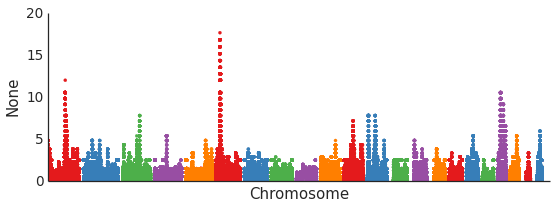

In [32]:
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,20], ticks=False)

In [ ]:
fig, axs = subplots(2,1, figsize=(10, 6))

ax = axs[0]
manhattan(-1*np.log10(biom_p), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,12], ax=ax, ticks=False)

ax.set_yticks(range(0, 13, 2))
#ax.set_yticklabels(range(0, 26, 5), size=14)
ax.set_xlabel('Chromosome', size=14)
axs[0].set_ylabel('-logP',
                  size=14)

ax = axs[1]
manhattan(-1*gwas['-logP'], gwas.chromosome, gwas.Map,
          ybound=[-12,0], ax=ax, flow='down')
ax.set_ylabel('GWAS P-value', size=14)
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_xticklabels(range(1,23), size=14)
ax.set_xlabel('')

fig.tight_layout()
fig.savefig(FIGDIR + 'fig3_cd_n.pdf', dpi=300)

In [42]:
dd = neu_down.ix[df_hiv.index].fillna(False)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p_gran = (v.dropna() * w).map(lookup).order()

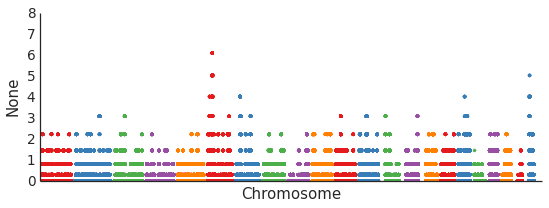

In [34]:
manhattan(-1*np.log10(biom_p_gran), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,8], ticks=False)

In [35]:
dd = cd4_down.ix[dx_hiv.index].fillna(False)
dd = dd.ix[fx.probe_idx].ix[ann.index].dropna()
m = dd.mean()
w = 200
t = lambda s: sp.stats.binom_test(s, w, p=m)
v = pd.concat([pd.rolling_mean(s, w, center=True) for i,s in 
               dd.groupby(ann.Chromosome)])
lookup = pd.Series({i: t(i) for i in (v.dropna() * w).unique()})
biom_p_cd4 = (v.dropna() * w).map(lookup).order()

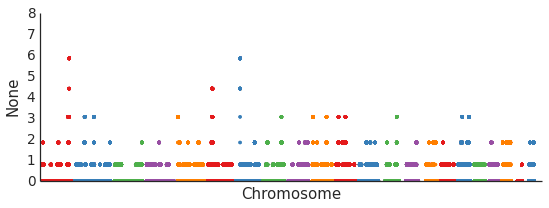

In [36]:
manhattan(-1*np.log10(biom_p_cd4), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,8], ticks=False)

In [43]:
gwas = pd.read_csv('./data/Euro_CHAVI_Setpoint_liftover.csv', index_col=0)
gwas.chromosome = gwas.chromosome.astype(str)

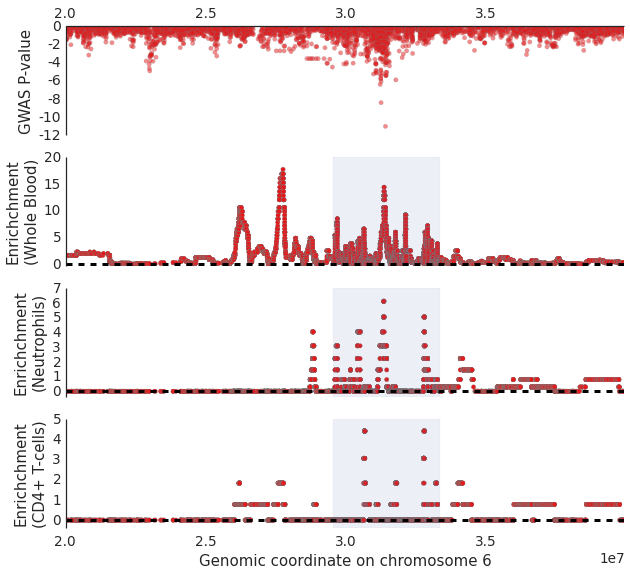

In [44]:
fig, axs  = subplots(4,1, figsize=(10,9), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

series_scatter(x, -1*np.log10(biom_p).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)
ax = axs[2]

series_scatter(x, -1*np.log10(biom_p_gran).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)


ax = axs[3]

series_scatter(x, -1*np.log10(biom_p_cd4).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

for ax in axs[1:]:
    ax.axhline(0, ls='--', color='black', lw=3)
    ax.set_ylabel('Enrichment')
    ax.spines['bottom'].set_visible(False)
    ax.axvspan(29570008, 33377112, alpha=.1)
    ax.set_xbound(x.min(), x.max())
    prettify_ax(ax)
    ax.set_xlabel('')
    ax.set_ybound(-.4)
    
axs[3].set_xlabel('Genomic coordinate on chromosome 6')

axs[1].set_ylabel('Enrichchment\n(Whole Blood)')
axs[2].set_ylabel('Enrichchment\n(Neutrophils)')
axs[3].set_ylabel('Enrichchment\n(CD4+ T-cells)')

In [54]:
cd4_down.value_counts()

False    15608
True       433
dtype: int64

In [57]:
x.min()

20014307

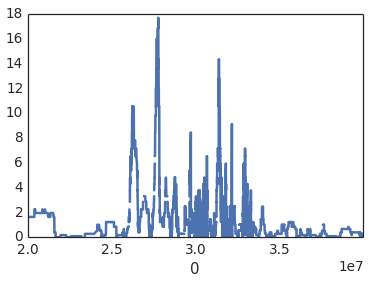

In [75]:
v = -1*np.log10(biom_p)


In [109]:
dark_red = sns.hls_palette(8, l=.45, s=.8)[0]

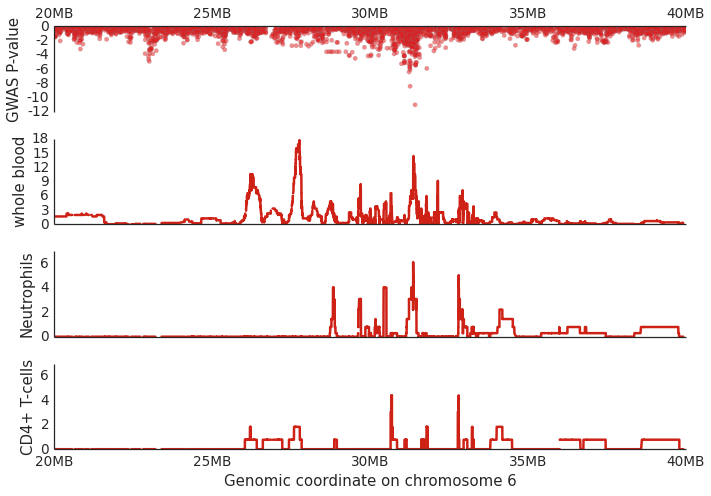

In [126]:
fig, axs  = subplots(4,1, figsize=(10,7), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

def line_plot(v, ax):
    df = pd.concat([x, v.ix[x.index.intersection(v.index)]], 1)
    s = df.set_index(0)[1]
    s.sort_index().plot(ax=ax, color=dark_red)
    prettify_ax(ax)
    ax.set_xbound(20000000, 40000000)
    ax.set_ybound(0)
    ax.set_xlabel('')
    
line_plot(-1*np.log10(biom_p), axs[1])
axs[1].set_yticks(range(0,19,3))
axs[1].set_ylabel('whole blood')
line_plot(-1*np.log10(biom_p_gran), axs[2])
axs[2].set_yticks(range(0,7,2))
axs[2].set_ybound(0,7)
axs[2].set_ylabel('Neutrophils')
line_plot(-1*np.log10(biom_p_cd4), axs[3])
axs[3].set_yticks(range(0,7,2))
axs[3].set_ybound(0,7)
axs[3].set_ylabel('CD4+ T-cells')
axs[3].set_xticklabels(['20MB','25MB','30MB','35MB','40MB'])
axs[3].set_xlabel('Genomic coordinate on chromosome 6')
fig.tight_layout()
fig.savefig(FIGDIR + 'bottom.pdf')

In [473]:
ann.ix[x.index.intersection(ti(neu_models.drop1.p < 10e-8))].sort('Genomic_Coordinate')

,Gene_Symbol,Chromosome,Genomic_Coordinate
cg24701809,HIST1H2AG;HIST1H2BJ,6,27101120
cg09855662,TRIM27,6,28892379
cg20136460,TRIM10,6,30128548
cg04278162,TRIM26,6,30182172
cg17633074,GTF2H4,6,30878864
cg25843003,HCP5,6,31431312
cg18821320,BAT1;SNORD84,6,31509875
cg03739609,LST1,6,31555016
cg01309328,PSMB8,6,32811253
cg25061610,HLA-DOA,6,32976049


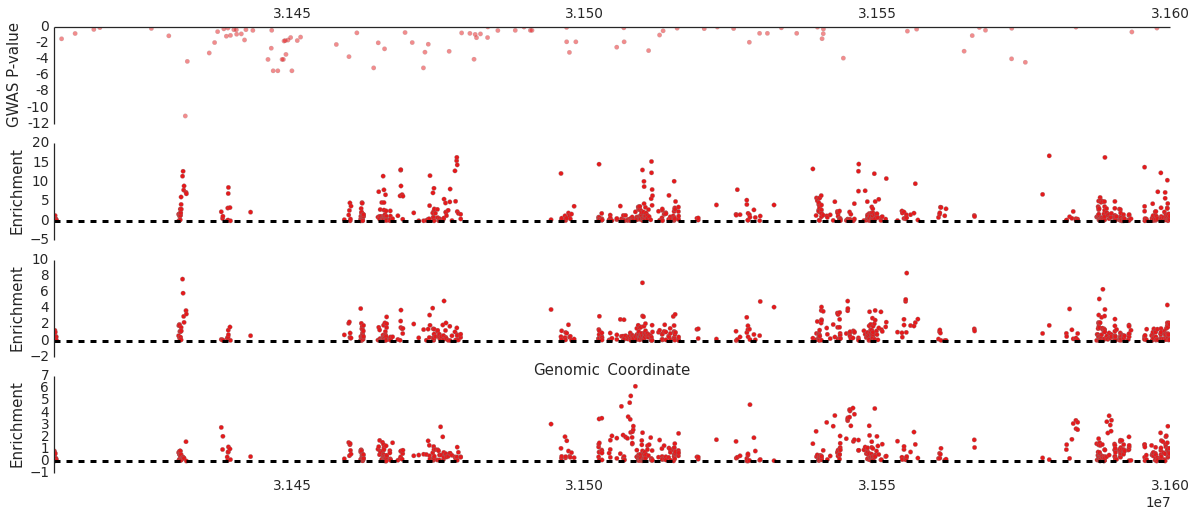

In [477]:
fig, axs  = subplots(4,1, figsize=(20,8), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(31000000, 32000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(31400000, 31600000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

series_scatter(x, -1*np.log10(fx.r4.HIV_LR.p).ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

ax = axs[2]

series_scatter(x, -1*np.log10(neu_models.drop1.p).ix[x.index], 
               s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)

ax = axs[3]
series_scatter(x, -1*np.log10(cd4_models.drop1.p).ix[x.index], 
               s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

In [92]:
odds_ratio(hiv_dx_gran == 'hiv_up', ann.Gene_Symbol == 'DDR1')

4.7722417163438786

In [90]:
ann.assign(hit=hiv_dx_gran).ix[biom_p_gran.index[:5]]

,Gene_Symbol,Chromosome,Genomic_Coordinate,hit
Composite Element REF,,,,
cg24646556,DDR1,6,30852566,neither
cg07939626,DDR1,6,30853073,neither
cg13695585,DDR1,6,30853014,hiv_up
cg11985839,DDR1,6,30853007,hiv_up
cg07816398,DDR1,6,30852545,neither


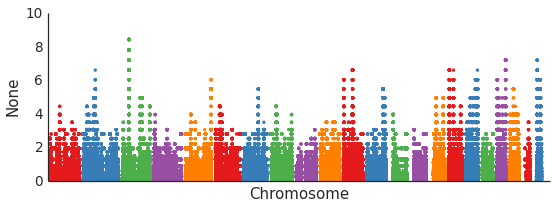

In [42]:
manhattan(-1*np.log10(biom_p_gran), ann.Chromosome, ann.Genomic_Coordinate,
          ybound=[0,10], ticks=False)

In [301]:
full_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 35000000)))
histone_region = ((ann.Chromosome == '6') & 
                   ann.Genomic_Coordinate.isin(range(25000000, 29570008)))
hla_region = ((ann.Chromosome == '6') & 
              ann.Genomic_Coordinate.isin(range(29570008, 33377112)))

In [307]:
fisher_exact_test(neu_down.ix[df_hiv.index].fillna(False), hla_region)

odds_ratio    1.39
p             0.03
dtype: float64

In [44]:
fisher_exact_test(dx_hiv == 'hiv_down', hla_region)

odds_ratio    1.35e+00
p             1.62e-22
dtype: float64

In [45]:
fisher_exact_test(dx_hiv == 'hiv_down', full_region)

odds_ratio    1.33e+00
p             3.13e-26
dtype: float64

In [67]:
fisher_exact_test(hiv_dx_gran == 'hiv_up', hla_region)

odds_ratio    4.49e-01
p             1.06e-24
dtype: float64

In [70]:
fisher_exact_test(hiv_dx_gran == 'hiv_up', full_region)

odds_ratio    6.99e-01
p             1.28e-09
dtype: float64

In [68]:
fisher_exact_test(hiv_dx_gran == 'hiv_down', hla_region)

odds_ratio    0.93
p             0.03
dtype: float64

In [47]:
tt = dx.ttest_df(hiv, df_hiv)

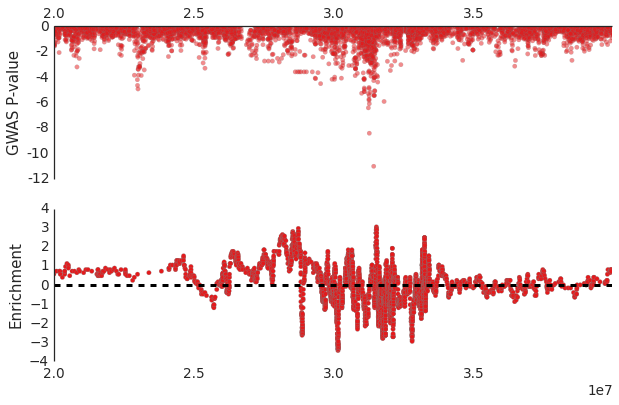

In [48]:
fig, axs  = subplots(2,1, figsize=(10,6), sharex=True)

ax=axs[0]
k = ti((gwas.chromosome == '6') & 
       gwas.Map.isin(range(20000000, 40000000)))
x = gwas.Map.ix[k]
rr = -1*gwas['-logP']

series_scatter(x, rr, color=colors[0],
               s=20, ax=ax, ann=None,
               edgecolor='grey')

ax.set_ylabel('GWAS P-value')
ax.set_yticks(range(-12, 1, 2))
ax.set_yticklabels(range(-12, 1, 2), size=14)
ax.set_ylim(-12,0)
ax.set_xlabel('')
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax, top=True)

k = ti((ann.Chromosome == '6') & 
       ann.Genomic_Coordinate.isin(range(20000000, 40000000)))
x = ann.Genomic_Coordinate.ix[k].order()

ax = axs[1]

d = (tt[tt.abs() > 0] > 0).ix[ann.index].dropna()
v = pd.concat([pd.rolling_mean(s, 200, center=True) for i,s in 
               d.groupby(ann.Chromosome)])
v = (v - v.mean()) / v.std()

series_scatter(x[::5], v.ix[x.index], s=20, ann=None, color=colors[0],
               edgecolor='grey', ax=ax, alpha=1)

ax.axhline(0, ls='--', color='black', lw=3)
ax.set_ylabel('Enrichment')
ax.spines['bottom'].set_visible(False)
#ax.axvspan(29570008, 33377112, alpha=.1)
ax.set_xbound(x.min(), x.max())
prettify_ax(ax)
ax.set_xlabel('')

In [174]:
f2 = {'gran-up': (hiv_dx_gran=='hiv_up') & (dx_hiv != 'age-up'), 
      'gran-down': (hiv_dx_gran=='hiv_down') & (dx_hiv != 'hiv_down'),
      'blood-up': (dx_hiv=='hiv_up') & (hiv_dx_gran != 'hiv_up'), 
      'blood-down': (dx_hiv=='hiv_down') & (hiv_dx_gran != 'hiv_down'),
      'both-up': (hiv_dx_gran=='hiv_up') & (dx_hiv=='hiv_up'),
      'both-down': (hiv_dx_gran=='hiv_down') & (dx_hiv=='hiv_down')}
probes_sets = {'PRC2': dx.prc2_probes, 'CpG island': dx.cpg_island,
               'DHS': dx.dhs_site, 'Enhancer': dx.enhancer,
               'Gene body': dx.gene_body, 'TSS': dx.gene_tss,
               'Promoter': dx.promoter}

In [175]:
associations = {}
for i,a in f2.iteritems():
    for j,b in probes_sets.iteritems():
        associations[(i,j)] = odds_ratio(a,b.ix[fx.probe_idx])
associations = pd.Series(associations)

In [176]:
o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['gran-up','both-up', 'blood-up']
df1 = associations.unstack().T.ix[o[::-1],p]

o = ['DHS','PRC2','CpG island','Enhancer', 'TSS','Gene body','Promoter']
p = ['gran-down','both-down', 'blood-down']
df2 = associations.unstack().T.ix[o[::-1],p]

In [177]:
cc = sns.color_palette()

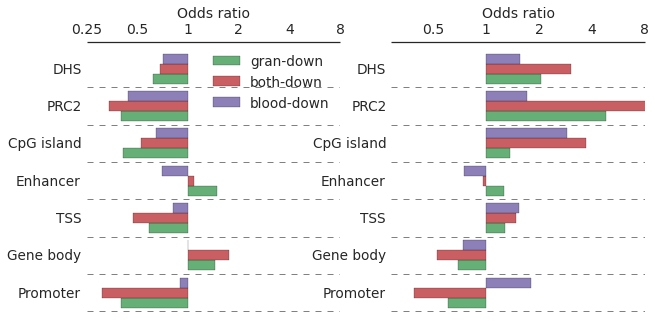

In [178]:
fig, axs = subplots(1,2, figsize=(10,5))
ax=axs[1]
ax.xaxis.tick_top()
np.log2(df1).plot(kind='barh', ax=ax, alpha=.9, width=.8, 
                               color=[cc[1],  cc[2], cc[3]])
ax.set_xticks([-3, -2,-1,0,1,2,3,4])
ax.set_xticklabels([.125, .25,.5,1,2,4,8,16], size=14)
ax.set_xbound(-1.8, 3.)
ax.set_ylim(-.75, 6.72)
ax.set_xlabel('Odds ratio', size=14)
ax.xaxis.set_label_position('top') 
ax.legend().set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_yticklabels(o[::-1], x=.1)
for i in range(len(o)):
    ax.axhline(i-.5, color='grey', ls='--', lw=1)
#ax.legend()
prettify_ax(ax, top=True)

ax=axs[0]
ax.xaxis.tick_top()
np.log2(df2).plot(kind='barh', ax=ax, alpha=.9, width=.8, 
                               color=[cc[1],  cc[2], cc[3]])
ax.set_xticks([-3, -2,-1,0,1,2,3,4])
ax.set_xticklabels([.125, .25,.5,1,2,4,8,16], size=14)
ax.set_xbound(-2, 3.)
ax.set_ylim(-.75, 6.72)
ax.set_xlabel('Odds ratio', size=14)
ax.xaxis.set_label_position('top') 
ax.legend().set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_yticklabels(o[::-1], x=.1)
for i in range(len(o)):
    ax.axhline(i-.5, color='grey', ls='--', lw=1)
ax.legend()
prettify_ax(ax, top=True)